In [1]:
import sys
import os
sys.path.insert(0, "../../")

import numpy as np
import pandas as pd
import random
from multiprocessing import Pool
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from time import time

from algorithms.epsnet import *
from algorithms.hittingset import *
from algorithms.fairness.fair_epsnet import *
from algorithms.fairness.fair_hittingset import *
from core.fairness import *
from core.ranges import get_range_space, BallRange
from core.points import Point

np.random.seed(42)
random.seed(42)

Load popsim dataset:

In [2]:
# Read the content of the file
with open("input_database.txt", "r") as file:
    data = file.read()

In [3]:
# Initialize variables
color = None
points = []

# Process each line in the data
for line in data.splitlines():
    line = line.strip()
    if line.isdigit():  # If the line is a number, it's a color
        color = int(line)
    elif line.startswith("(") and line.endswith(")"):  # If the line is a pair (lat, long)
        lat, long = map(float, line.strip("()").split(", "))
        points.append(Point(point=(lat, long), color=color - 1))
del data
points = [p for p in points if p.color != -1]
points = random.sample(points, 2**14)
len(points)

16384

In [4]:
n = len(points)
n = 2**(int(math.log(n, 2)))
m = 2048
vc = 3 # balls in plane
k = 4

print(n, m)

16384 2048


In [5]:
def get_range_space(points: List[Point], ranges: List[Range]) -> List[Set[Point]]:
    """
    Keeps track of points contained in each range.
    """
    rangespace = []
    for r in tqdm(ranges):
        subset = [p for p in points if r.contains(p)]
        rangespace.append(set(subset))
    return rangespace

In [6]:
# Define the radius
radius = 20000

centers = random.sample(points, m)

print("Creating ranges...")
ranges = [BallRange(center=center, radius=radius) for center in centers]

print("Creating rangespace...")
rangespace = get_range_space(points=points, ranges=ranges)

print(n, m)

Creating ranges...
Creating rangespace...


100%|██████████| 2048/2048 [00:36<00:00, 55.52it/s]

16384 2048


In [7]:
epss = [0, 0.2, 0.4, 0.63, 0.65, 0.66]

for eps in epss:
    tmp = [r for r in rangespace if len(r) > eps * n]
    print(f"eps: {eps}, heavy ranges: {len(tmp)}")

eps: 0, heavy ranges: 2048
eps: 0.2, heavy ranges: 1307
eps: 0.4, heavy ranges: 1277
eps: 0.63, heavy ranges: 912
eps: 0.65, heavy ranges: 335
eps: 0.66, heavy ranges: 128


In [8]:
ratios = []
for color in range(k):
    ratios.append(
        len([p for p in points if p.color == color]) / n
    )
    print(f"Color: {color}: {len([p for p in points if p.color == color])}")
ratios = [rate / sum(ratios) for rate in ratios]

Color: 0: 138
Color: 1: 1123
Color: 2: 2813
Color: 3: 12310


In [9]:
def l2_norm(vector1, vector2):
    """
    Compute the L2 norm (Euclidean distance) between two vectors.
    """
    return np.sqrt(np.sum((np.array(vector1) - np.array(vector2))**2))

def linf_norm(vector1, vector2):
    """
    Compute the L∞ norm (maximum absolute difference) between two vectors.
    """
    return np.max(np.abs(np.array(vector1) - np.array(vector2)))

## Fair and Standard EpsNet

In [10]:
def get_fairness_l2(subset, points):
    """
    Compute the fairness of a subset of points.
    """
    sub_ratios = []
    for color in range(k):
        sub_ratios.append(
            len([p for p in subset if p.color == color]) / len(subset)
        )
    ratios = []
    for color in range(k):
        ratios.append(
            len([p for p in points if p.color == color]) / n
        )
    return l2_norm(sub_ratios, ratios)

def get_fairness_linf(subset, points):
    """
    Compute the fairness of a subset of points.
    """
    sub_ratios = []
    for color in range(k):
        sub_ratios.append(
            len([p for p in subset if p.color == color]) / len(subset)
        )
    ratios = []
    for color in range(k):
        ratios.append(
            len([p for p in points if p.color == color]) / n
        )
    return linf_norm(sub_ratios, ratios)

In [11]:
result = {
    "eps": [],
    "epsnet_size": [],
    "fair_epsnet_size": [],
    "epsnet_fairness_l2": [],
    "fair_epsnet_fairness_l2": [],
    "epsnet_fairness_linf": [],
    "fair_epsnet_fairness_linf": [],
    "unfair_time": [],
    "fair_time": []
}

for eps in epss[1:]:
    start = time()
    epsnet = build_epsnet_sample(
        points=points, 
        rangespace=rangespace,
        vc=vc,
        epsilon=eps,
        success_prob=0.9,
        weights=None,
        c1=1
    )
    middle = time()
    epsnet_time = middle - start
    fair_epsnet = build_fair_epsnet_sample(
        points=points,
        rangespace=rangespace,
        vc=vc,
        epsilon=eps,
        success_prob=0.9,
        weights=None,
        c1=1/2,
        c2=1,
        color_ratios=ratios,
        fairconfig=FairConfig(
            k=k,
            fairness=FairnessMeasure.DP
        )
    )
    fair_epsnet_time = time() - middle
    
    len_epsnet = len(epsnet)
    len_fair_epsnet = len(fair_epsnet)
    len_points = len(points)
    
    fairness_epsnet_l2 = get_fairness_l2(epsnet, points)
    fairness_epsnet_linf = get_fairness_linf(epsnet, points)
    fairness_fair_epsnet_l2 = get_fairness_l2(fair_epsnet, points)
    fairness_fair_epsnet_linf = get_fairness_linf(fair_epsnet, points)
    
    result["eps"].append(eps)
    result["epsnet_size"].append(len_epsnet)
    result["fair_epsnet_size"].append(len_fair_epsnet)
    result["epsnet_fairness_l2"].append(fairness_epsnet_l2)
    result["fair_epsnet_fairness_l2"].append(fairness_fair_epsnet_l2)
    result["epsnet_fairness_linf"].append(fairness_epsnet_linf)
    result["fair_epsnet_fairness_linf"].append(fairness_fair_epsnet_linf)
    result["unfair_time"].append(epsnet_time)
    result["fair_time"].append(fair_epsnet_time)
    
result = pd.DataFrame(result)

[build_epsnet_sample] epsnet size m: 759
[build_fair_epsnet_sample] epsnet size m: 759, v: 1.5
[_augment_epsnet] epsnet colors count:
	[_augment_epsnet] Color 0: 9
	[_augment_epsnet] Color 1: 47
	[_augment_epsnet] Color 2: 124
	[_augment_epsnet] Color 3: 579
[_augment_epsnet] Color 0 to add: 0
[_augment_epsnet] Color 1 to add: 31
[_augment_epsnet] Color 2 to add: 71
[_augment_epsnet] Color 3 to add: 276
[_augment_epsnet] epsnet colors count after augmentation:
	[_augment_epsnet] Color 0: 9
	[_augment_epsnet] Color 1: 78
	[_augment_epsnet] Color 2: 195
	[_augment_epsnet] Color 3: 855
[build_epsnet_sample] epsnet size m: 320
[build_fair_epsnet_sample] epsnet size m: 320, v: 1.5
[build_fair_epsnet_sample] Bad epsnet, resampling...
[_augment_epsnet] epsnet colors count:
	[_augment_epsnet] Color 0: 2
	[_augment_epsnet] Color 1: 19
	[_augment_epsnet] Color 2: 65
	[_augment_epsnet] Color 3: 234
[_augment_epsnet] Color 0 to add: 2
[_augment_epsnet] Color 1 to add: 13
[_augment_epsnet] Color 2 

In [ ]:
# result.to_csv("epsnet_popsim.csv", index=False)

In [13]:
for color in range(k):
    print(
        len([p for p in points if p.color == color]) / len(points)
    )

0.0084228515625
0.06854248046875
0.17169189453125
0.7513427734375


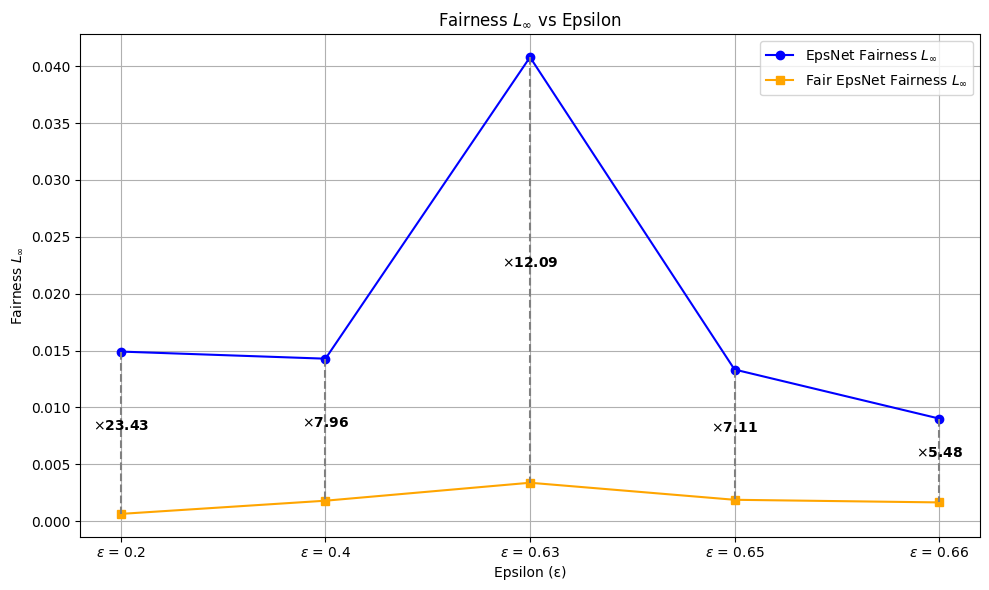

In [14]:
import matplotlib.pyplot as plt

# Labels and epsilon values
eps_labels = ["$\epsilon$ = 0.2", "$\epsilon$ = 0.4", "$\epsilon$ = 0.63", "$\epsilon$ = 0.65", "$\epsilon$ = 0.66"]

# Example data — replace with your actual results
epsnet_fairness = result["epsnet_fairness_linf"]
fair_epsnet_fairness = result["fair_epsnet_fairness_linf"]

plt.figure(figsize=(10, 6))

# Plot the two lines
plt.plot(eps_labels, epsnet_fairness, label="EpsNet Fairness $L_\infty$", color="blue", marker="o")
plt.plot(eps_labels, fair_epsnet_fairness, label="Fair EpsNet Fairness $L_\infty$", color="orange", marker="s")

# Annotate vertical improvements
for i, label in enumerate(eps_labels):
    y1 = epsnet_fairness[i]
    y2 = fair_epsnet_fairness[i]

    # Add vertical line
    plt.plot([label, label], [y1, y2], color="gray", linestyle="--")

    # Add annotation for improvement
    improvement = y1 / y2
    y_mid = (y1 + y2) / 2
    plt.text(i, y_mid, f"$\\times${improvement:.2f}", ha='center', va='bottom', fontsize=10, color="black", weight="bold")

# Labels and formatting
plt.xlabel("Epsilon (ε)")
plt.ylabel("Fairness $L_\infty$")
plt.title("Fairness $L_\infty$ vs Epsilon")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

# Create a DataFrame for the table
table_data = {
    "Epsilon (ε)": eps_labels,
    "EpsNet Fairness $L_\infty$": epsnet_fairness,
    "Fair EpsNet Fairness $L_\infty$": fair_epsnet_fairness,
    "Improvement (×)": [y1 / y2 for y1, y2 in zip(epsnet_fairness, fair_epsnet_fairness)]
}

fairness_table = pd.DataFrame(table_data)

# Display the table
fairness_table


,Epsilon (ε),EpsNet Fairness $L_\infty$,Fair EpsNet Fairness $L_\infty$,Improvement (×)
0,$\epsilon$ = 0.2,0.014907,0.000636,23.433768
1,$\epsilon$ = 0.4,0.014282,0.001795,7.955334
2,$\epsilon$ = 0.63,0.040792,0.003374,12.089374
3,$\epsilon$ = 0.65,0.013329,0.001876,7.105644
4,$\epsilon$ = 0.66,0.009019,0.001645,5.481560


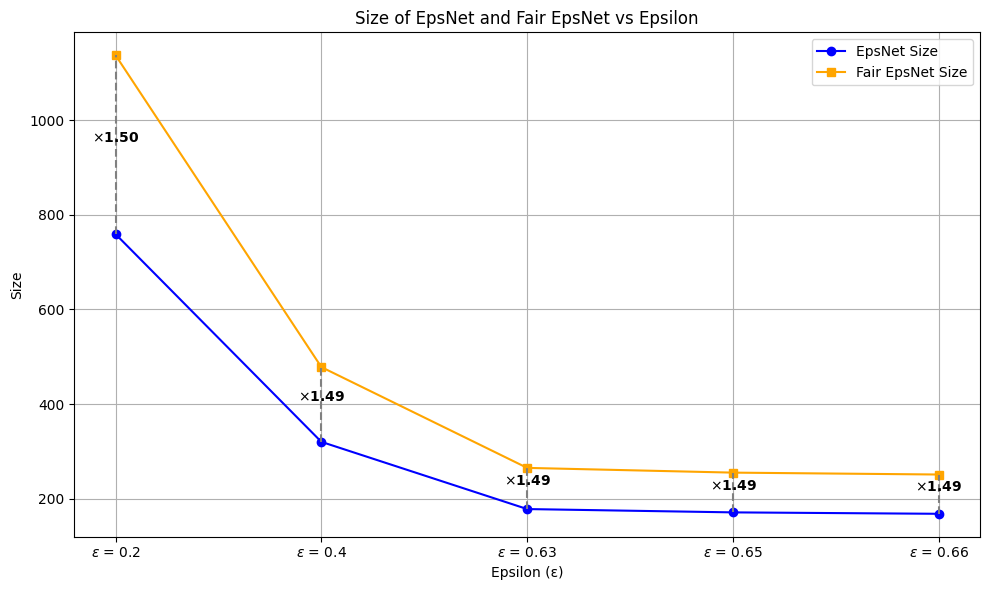

In [16]:
import matplotlib.pyplot as plt

eps_labels = ["$\epsilon$ = 0.2", "$\epsilon$ = 0.4", "$\epsilon$ = 0.63", "$\epsilon$ = 0.65", "$\epsilon$ = 0.66"]

epsnet_size = result["epsnet_size"]
fair_epsnet_size = result["fair_epsnet_size"]

plt.figure(figsize=(10, 6))

# Plot the two lines
plt.plot(eps_labels, epsnet_size, label="EpsNet Size", color="blue", marker="o")
plt.plot(eps_labels, fair_epsnet_size, label="Fair EpsNet Size", color="orange", marker="s")

# Add vertical lines and ratio annotations
for i, label in enumerate(eps_labels):
    y1 = epsnet_size[i]
    y2 = fair_epsnet_size[i]

    # Vertical line between epsnet and fair_epsnet
    plt.plot([label, label], [y1, y2], color="gray", linestyle="--")

    # Ratio annotation
    if y1 != 0:
        ratio = y2 / y1
        y_mid = (y1 + y2) / 2
        plt.text(i, y_mid, f"$\\times${ratio:.2f}", ha='center', va='bottom', fontsize=10, weight="bold", color="black")

plt.xlabel("Epsilon (ε)")
plt.ylabel("Size")
plt.title("Size of EpsNet and Fair EpsNet vs Epsilon")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
print("Times:")
result["unfair_time"].mean(), result["fair_time"].mean()


Times:


(np.float64(0.00017189979553222656), np.float64(0.008990049362182617))

In [22]:
result = {
    "hittingset_size": [],
    "fair_hittingset_size": [],
    "hittingset_fairness_l2": [],
    "fair_hittingset_fairness_l2": [],
    "hittingset_fairness_linf": [],
    "fair_hittingset_fairness_linf": [],
    "unfair_time": [],
    "fair_time": []
}

for i in range(5): # 10 iterations
    print(f"iterations: {i + 1} / {5}")
    start = time()
    print("Finding hittingset...")
    hittingset = find_hitting_set_geometric(
        points = points,
        rangespace=rangespace,
        vc=vc
    )
    middle = time()
    hittingset_time = middle - start
    print("Finding fair hittingset...")
    fair_hittingset = find_fair_hitting_set_geometric(
        points = points,
        rangespace=rangespace,
        vc=vc,
        fairconfig=FairConfig(
            k=k,
            fairness=FairnessMeasure.DP
        ),
        c1=1/2,
    )
    fair_hittingset_time = time() - middle
    
    len_hittingset = len(hittingset)
    len_fair_hittingset = len(fair_hittingset)
    len_points = len(points)
    
    fairness_hittingset_l2 = get_fairness_l2(hittingset, points)
    fairness_hittingset_linf = get_fairness_linf(hittingset, points)
    fairness_fair_hittingset_l2 = get_fairness_l2(fair_hittingset, points)
    fairness_fair_hittingset_linf = get_fairness_linf(fair_hittingset, points)
    
    result["hittingset_size"].append(len_hittingset)
    result["fair_hittingset_size"].append(len_fair_hittingset)
    result["hittingset_fairness_l2"].append(fairness_hittingset_l2)
    result["fair_hittingset_fairness_l2"].append(fairness_fair_hittingset_l2)
    result["hittingset_fairness_linf"].append(fairness_hittingset_linf)
    result["fair_hittingset_fairness_linf"].append(fairness_fair_hittingset_linf)
    result["unfair_time"].append(epsnet_time)
    result["fair_time"].append(fair_epsnet_time)
    
result = pd.DataFrame(result)

iterations: 1 / 10
Finding hittingset...
[find_hitting_set_geometric] epsilon: 0.12500000000000003
[build_epsnet_sample] epsnet size m: 336
[find_hitting_set_geometric] epsnet size: 336
Finding fair hittingset...
[find_hitting_set_geometric] epsilon: 0.12499999999999994
[find_hitting_set_geometric] weights by color: [np.float64(0.0084228515625), np.float64(0.06854248046875), np.float64(0.1716918945312509), np.float64(0.7513427734375003)]
[build_fair_epsnet_sample] epsnet size m: 337, v: 1.5
[_augment_epsnet] epsnet colors count:
	[_augment_epsnet] Color 0: 2
	[_augment_epsnet] Color 1: 24
	[_augment_epsnet] Color 2: 60
	[_augment_epsnet] Color 3: 251
[_augment_epsnet] Color 0 to add: 2
[_augment_epsnet] Color 1 to add: 10
[_augment_epsnet] Color 2 to add: 26
[_augment_epsnet] Color 3 to add: 128
[_augment_epsnet] epsnet colors count after augmentation:
	[_augment_epsnet] Color 0: 4
	[_augment_epsnet] Color 1: 34
	[_augment_epsnet] Color 2: 86
	[_augment_epsnet] Color 3: 379
[find_fair_

In [ ]:
# result.to_csv("hittingset_popsim.csv", index=False)

In [25]:
# Create a DataFrame for the table
table_data = {
    "Epsilon (ε)": [0],
    "HittingSet Fairness $L_\infty$": [result["hittingset_fairness_linf"].mean()],
    "Fair HittinSet Fairness $L_\infty$": [result["fair_hittingset_fairness_linf"].mean()],
    "Improvement (×)": [result["hittingset_fairness_linf"].mean() / result["fair_hittingset_fairness_linf"].mean()]
}

fairness_table = pd.DataFrame(table_data)

# Display the table
fairness_table

,Epsilon (ε),HittingSet Fairness $L_\infty$,Fair HittinSet Fairness $L_\infty$,Improvement (×)
0,0,0.093895,0.002136,43.951245


In [27]:
# Create a DataFrame for the table
table_data = {
    "Epsilon (ε)": [0],
    "HittingSet Size": [result["hittingset_size"].mean()],
    "Fair HittinSet size": [result["fair_hittingset_size"].mean()],
    "Rate (×)": [result["fair_hittingset_size"].mean() / result["hittingset_size"].mean()]
}

fairness_table = pd.DataFrame(table_data)

# Display the table
fairness_table

,Epsilon (ε),HittingSet Size,Fair HittinSet size,Rate (×)
0,0,336.0,503.0,1.497024


In [29]:
# Create a DataFrame for the table
table_data = {
    "Epsilon (ε)": [0],
    "HittingSet Time": [result["unfair_time"].mean()],
    "Fair HittinSet Time": [result["fair_time"].mean()],
    # "Improvement (×)": [result["hittingset_fairness_linf"].mean() / result["fair_hittingset_fairness_linf"].mean()]
}

fairness_table = pd.DataFrame(table_data)

# Display the table
fairness_table

,Epsilon (ε),HittingSet Time,Fair HittinSet Time
0,0,0.000108,0.006431
